In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models import vgg19, vgg16, resnet18
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
plt.rcParams["figure.figsize"] = (10,10)

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [5]:
PATH_TRAIN = './drive/MyDrive/data_tp3/train.pkl'
PATH_TEST = './drive/MyDrive/data_tp3/test.pkl'
PATH_LABEL = './drive/MyDrive/data_tp3/train_y.csv'

# Load Dataset

In [6]:
images_train = pd.read_pickle(PATH_TRAIN)
images_test = pd.read_pickle(PATH_TEST)
y_train = np.array(pd.read_csv(PATH_LABEL, index_col=0))

# Data visualisation

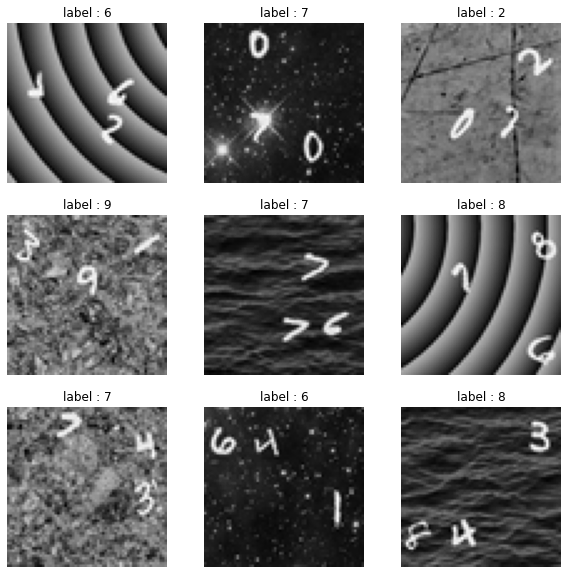

In [7]:
fig, ax = plt.subplots(3,3)
plot_index = [(i, j) for i in range(3) for j in range(3)]
for image, i, label in zip(images_train, plot_index, y_train):
    ax[i].axis('off')
    ax[i].imshow(image, cmap="gray")
    ax[i].set_title(f'label : {label[0]}')

# Encode Data

In [8]:
# One hot encoding 
def to_categorical(y, num_classes):
    return np.eye(num_classes)[y]

# Encode Y to categorical because we have 10 predictions classes
y_train = to_categorical(y_train, 10)

# Data loader

In [9]:
class CustomMNIST(Dataset):
    def __init__(self, img_path, csv_path, transform=None):
        img = pd.read_pickle(img_path)
        self.img = np.repeat(img[..., np.newaxis], 3, -1)
        self.csv_path = csv_path
        self.img_labels = pd.read_csv(csv_path, index_col=0)
        self.transform = transform

    def __len__(self):
        return self.img.shape[0]

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform:
            image = self.transform(image)
            
        label = self.img_labels.iloc[idx, 0] 
        return image, label

In [10]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__()

    # On crée le réseau de neuronne pré-entrainé
    self.model = vgg19(pretrained=True)

    # On récupère le nombre de neurones avant la couche de classification
    dim_before_fc = self.model.classifier[6].in_features

    # On change la dernière couche (fully-connected layer) pour avoir le bon nombre de neuronnes en sortie
    self.model.classifier[6] = nn.Linear(dim_before_fc, 10)

    # On gèle les paramètres hormis la couche fc
    for name, param in self.model.named_parameters():
        if name != 'classifier.6.weight' and name != 'classifier.6.weight.bias':
            param.requires_grad = False

  def forward(self, x):
    x = self.model(x)
    return x

In [11]:
# Variables
nb_epochs = 10
lr = 0.01
batch_size = 1
shuffle = True
pin_memory = True
momentum = 0.9

In [12]:
# Create dataloaders
transform = T.Compose([T.ToTensor(), T.Resize((64,64)), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = CustomMNIST(img_path=PATH_TRAIN, csv_path=PATH_LABEL, transform=transform)

train_set, val_set = torch.utils.data.random_split(dataset, [35000, 5000])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size, pin_memory=pin_memory)
val_loader = DataLoader(dataset=val_set, shuffle=shuffle, batch_size=batch_size, pin_memory=pin_memory)

In [13]:
# Create model
model = CNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = Adam(model.parameters(), lr = 0.001)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [14]:
# Accuracy
def accuracy(dataloader, model):
  model.eval()
  good = 0
  total = 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(DEVICE)
      y = y.to(DEVICE)

      scores = model(X)
      pred = []
      top1 = 0
      idx_top1 = 0
      top2 = 0
      idx_top2 = 0
      top3 = 0
      idx_top3 = 0
      for i in range(len(scores[0])):
        if scores[0][i] >= top1:
          top3 = top2
          idx_top3 = idx_top2
          top2 = top1
          idx_top2 = idx_top1
          top1 = scores[0][i]
          idx_top1 = i
          
        elif scores[0][i] >= top2:
          top3 = top2 
          idx_top3 = idx_top2
          top2 = scores[0][i]
          idx_top2 = i

        elif scores[0][i] >= top3:
          top3 = scores[0][i]
          idx_top3 = i
      
      val_max = max(idx_top1, idx_top2, idx_top3) # return max of top 3 predictions --> 24%
      #val_max = idx_top1 # return max of prediction --> 18%
      
      predictions = torch.tensor(pred).to(DEVICE)
      if val_max == y:
        good += 1
      total += 1

  return good/total

In [15]:
def train():
  model.train()
  for epoch in range(2):
    for image, label in tqdm(train_loader):
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      prediction = model(image)
      loss = criterion(prediction, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

In [16]:
train()

100%|██████████| 35000/35000 [02:52<00:00, 203.29it/s]


In [18]:
accuracy(val_loader, model)

0.2574